# Time Series Forecasting with Facebook Prophet Notebook

In [64]:
# General packages
import pandas as pd
import numpy as np

# Plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Forecasting related packages
import datetime
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_components
from statsmodels.tools.eval_measures import rmse

In [3]:
# Read data
coffee_df = pd.read_csv(
    r"C:\Users\evans\PycharmProjects\coffee_stock_price_forecast\data\coffee.csv"
)

In [4]:
# Print the shape of the DataFrame and show first 5 rows
print(coffee_df.shape)
coffee_df.head()

(5746, 7)


,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD


In [6]:
# Convert date column to datetime and drop all columns besides 'Date' and 'Close'
coffee_df["Date"] = pd.to_datetime(coffee_df["Date"])
coffee_df = coffee_df[["Date", "Close"]]

## Exploratory Data Analysis (EDA)

In [7]:
# Check data types of coffee_df columns post transformation
coffee_df.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [9]:
# Summary Stats
coffee_df.describe()

,Date,Close
count,5746,5746.000000
mean,2011-05-17 10:11:14.138531072,127.215567
min,2000-01-03 00:00:00,41.500000
25%,2005-10-11 06:00:00,98.650000
50%,2011-05-16 12:00:00,120.250000
75%,2016-12-19 18:00:00,144.337500
max,2022-09-02 00:00:00,304.900000
std,NaN,50.506519


From the beginning of the year 2000 to the end of 2022, this coffee stocks close price range is fairly wide - the max price was $304.90/share and min was $41.50/share. The average close price in this time period was $127.26/share and standard deviation was $50.51/share.

In [141]:
# Check for NA values
coffee_df.isna().sum()

Date     0
Close    0
dtype: int64

In [38]:
# Resample the data on mean 'Close' price weekly
sale_weekly = coffee_df.resample("W", on="Date").mean()

# Resample the data on mean 'Close' price monthly
sale_monthly = coffee_df.resample("M", on="Date").mean()

In [39]:
print(sale_monthly.shape)
print(sale_weekly.shape)

(273, 5)
(1183, 5)


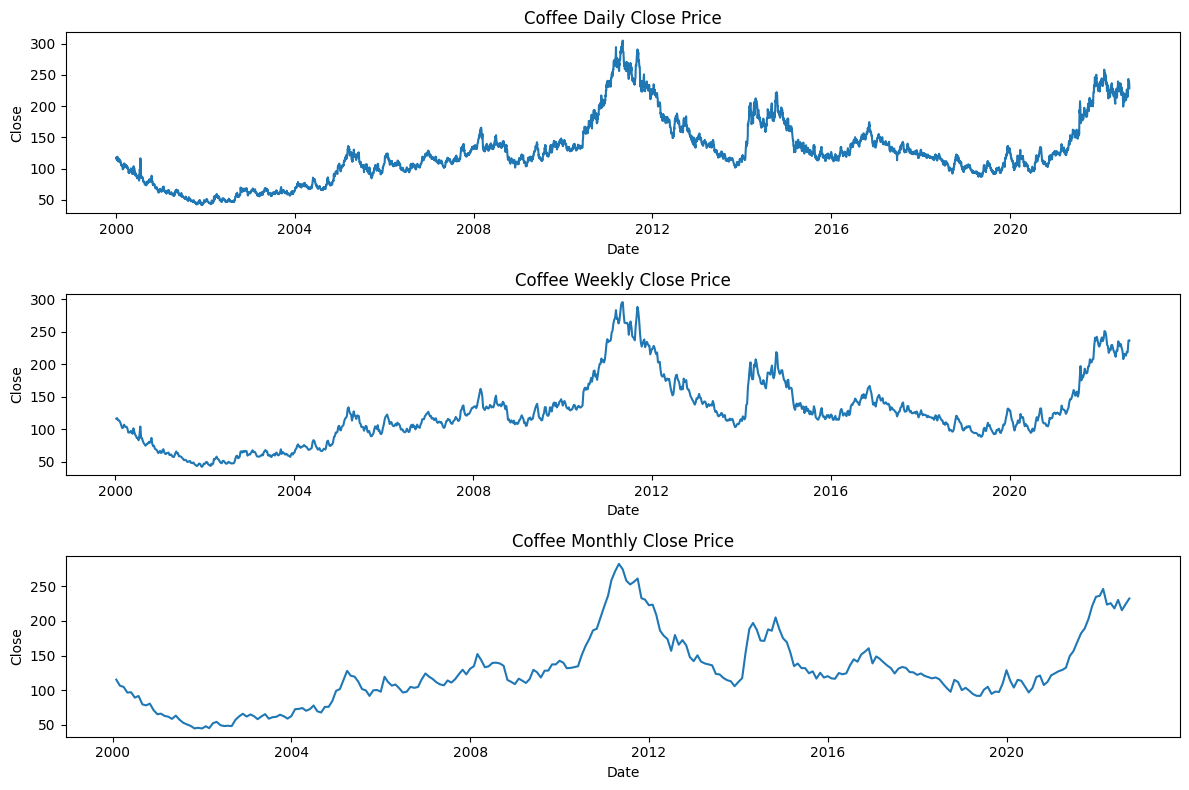

In [40]:
# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 8))

sns.lineplot(x="Date", y="Close", data=coffee_df, ax=ax1)
ax1.set_title("Coffee Daily Close Price")

sns.lineplot(x="Date", y="Close", data=sale_weekly, ax=ax2)
ax2.set_title("Coffee Weekly Close Price")

sns.lineplot(x="Date", y="Close", data=sale_monthly, ax=ax3)
ax3.set_title("Coffee Monthly Close Price")

plt.tight_layout()

In [29]:
def make_forecast(
    df,
    date_col,
    value_col,
    forecast_periods=365,
    yearly_seasonality=True,
    output_option="forecast",
):
    """
    Create a forecast using Prophet and choose the type of output.

    Parameters:
    ----------
        df (pd.DataFrame): DataFrame containing the time series data.
        date_col (str): Name of the column in the DataFrame representing the date/datetime.
        value_col (str): Name of the column in the DataFrame representing the value to forecast.
        forecast_periods (int): Number of periods to forecast into the future (default: 365).
        yearly_seasonality (bool): Include yearly seasonality in the forecast (default: True).
        output_option (str): Choose the type of output ("forecast" for forecast DataFrame or "test_set" for the test set).

    Returns:
    -------
        result: Either the forecast DataFrame or the forecasted values on the test set based on the output_option parameter.
        p (Prophet model): Fitted model of Prophet object.
        test_set: Test set of the last year of data (for plotting later).
    """

    # Parameter validation
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input 'df' must be a pandas DataFrame.")
    if date_col not in df.columns or value_col not in df.columns:
        raise ValueError(
            f"'{date_col}' and '{value_col}' must be columns in the input DataFrame."
        )

    # Rename columns to match Prophet's requirements
    new_df = df.rename(columns={date_col: "ds", value_col: "y"}, inplace=False)
    new_df = new_df[["ds", "y"]]

    # Splitting train-test sets
    train_set = new_df[:-forecast_periods]
    test_set = new_df[-forecast_periods:]

    # Fit the model to the train data
    p = Prophet(yearly_seasonality=yearly_seasonality)
    p.add_country_holidays(country_name="US")
    p.fit(train_set)

    # Make a future DataFrame for forecasting
    future = p.make_future_dataframe(periods=forecast_periods)

    if output_option == "forecast":
        # Make a forecast using the future DataFrame
        forecast = p.predict(future)
        return forecast, p

    elif output_option == "test_set":
        # Forecast on the test set
        forecast_on_test = p.predict(test_set)
        return forecast_on_test, p, test_set

In [31]:
# Create variables for both scenarios
forecast, p = make_forecast(coffee_df, "Date", "Close", output_option="forecast")
forecast_on_test, p, test_set = make_forecast(
    coffee_df, "Date", "Close", output_option="test_set"
)

20:38:20 - cmdstanpy - INFO - Chain [1] start processing
20:38:21 - cmdstanpy - INFO - Chain [1] done processing
20:38:23 - cmdstanpy - INFO - Chain [1] start processing
20:38:24 - cmdstanpy - INFO - Chain [1] done processing


### Code Explanation

The code above employs the `make_forecast` function to generate two distinct forecast scenarios using the 'coffee_df' time series dataset. In the first scenario, the function is called with 'output_option' set to 'forecast,' producing a forecast DataFrame ('forecast') containing predictions and uncertainty intervals for future periods, along with the fitted Prophet model ('p'). In the second scenario, 'output_option' is set to 'test_set,' yielding a forecast DataFrame ('forecast_on_test') based on the test set, allowing model evaluation on unseen data. The function returns the same fitted Prophet model ('p') in both scenarios, along with the test set ('test_set') containing the actual values corresponding to the forecasted periods. This approach provides flexibility for both visualizing forecasts and assessing the model's performance against real data.

In [22]:
forecast.loc[:, :"yhat_upper"].tail()

,ds,trend,yhat_lower,yhat_upper
5741,2022-03-20,94.754150,60.983080,129.518091
5742,2022-03-21,94.734311,60.488702,128.095643
5743,2022-03-22,94.714472,60.622476,128.146852
5744,2022-03-23,94.694633,57.667763,126.411622
5745,2022-03-24,94.674794,56.004575,127.112181


### Summary of the Forecast Output DataFrame from Prophet

1. **'ds' (Date or Time):** This column represents the date or timestamp for each forecasted value. It spans the original historical data period as well as the future periods for which the forecast was generated.

2. **'yhat' (Forecasted Value):** This column contains the predicted values for the time series. It represents the forecasted values based on the model's predictions.

3. **'yhat_lower' and 'yhat_upper' (Uncertainty Intervals):** These columns define the lower and upper bounds of the uncertainty intervals around the forecasted values. The forecasted value ('yhat') falls within this interval with a specified confidence level.

4. **'trend' (Trend Component):** This column represents the estimated trend component of the time series. It provides insights into the overall direction or trend in the forecast.

5. **Additional Columns (if included):** Depending on the settings and components configured in the Prophet model, additional columns may be present in the forecast output DataFrame. For example, if yearly seasonality is included, there may be columns for 'yearly' seasonality components.

## Time Series Plots

In [15]:
plot_plotly(p, forecast)

In this plot, we can observe the performance of our estimated close price (yhat), represented by the blue line. The estimated close price aligns reasonably well with the actual close prices (y), which are indicated by the black dots. The light blue shaded region encompasses the uncertainty range of our estimated close price. The upper bound of this shaded region corresponds to yhat_upper, while the lower bound corresponds to yhat_lower. As we move towards the rightmost region of the plot, which represents the last year of our test data, we notice a divergence between the estimated close price and the actual values. This indicates that our estimate begins to deviate from the actual values in this period, suggesting room for improvement in our forecasting model for this specific timeframe.

Text(0.5, 1.0, 'Close Price Time Series Forecasting')

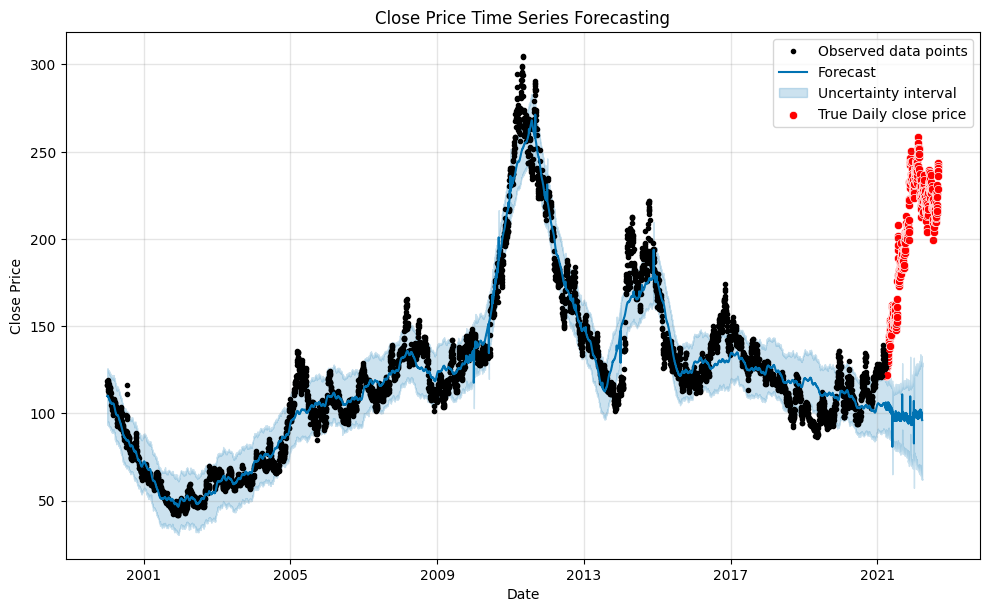

In [16]:
# Plot the forecast results
pred_plot = p.plot(forecast)
sns.scatterplot(x="ds", y="y", data=test_set, color="r", label="True Daily close price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price Time Series Forecasting")

In this slightly more granular plot, I include a key in the top right corner that denotes all elements of the plot which were shared by the previous besides the "True Daily close price" illustrated by the red points. These are the actual test set values contained in the last year of our dataset. Immediately, it is obvious that our prophet forecasting model is very far off the mark when it comes to predicting coffee stock close prices in the last year of this dataset.

## Evaluate Model

In [17]:
predictions = forecast.iloc[-365:]["yhat"]
print(
    f"Root Mean Squared Error (RMSE) between actual and predicted values: {rmse(predictions, test_set['y'])}"
)
print(f"Mean value of Test Dataset: {test_set['y'].mean()}")

Root Mean Squared Error (RMSE) between actual and predicted values: 110.24284082187903
Mean value of Test Dataset: 202.2961095890411


## Additional Features: Trend, Seasonality, and Holidays

In [58]:
def create_prophet_plots(df, super_title):
    """
    Create subplots for Prophet forecast analysis.

    Parameters:
    ----------
        df (pd.DataFrame): DataFrame containing the time series data.
        super_title (str): Super title for the entire figure.

    Returns:
    -------
        fig: Plotly figure object containing subplots.
    """
    # Sort the DataFrame by the date column
    prophet_plot_forecast = df.sort_values(by="ds")

    # Create subplots
    fig = make_subplots(rows=3, cols=1, subplot_titles=("Trend", "Season", "Holidays"))

    # Add traces (scatter plots) to each subplot
    fig.add_trace(
        go.Scatter(
            x=prophet_plot_forecast["ds"],
            y=prophet_plot_forecast["trend"],
            showlegend=False,
        ),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=prophet_plot_forecast["ds"],
            y=prophet_plot_forecast["season"],
            showlegend=False,
        ),
        row=2,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=prophet_plot_forecast["ds"],
            y=prophet_plot_forecast["holidays"],
            showlegend=False,
        ),
        row=3,
        col=1,
    )

    # Update the layout to include a title for the entire figure
    fig.update_layout(
        title=super_title,
        title_x=0.5,
        title_font=dict(size=24),  # Set the title font size
        font=dict(size=18),  # Set the general font size (axis labels, etc.)
    )

    return fig

In [36]:
# prepare for plotting on the predicted values from test set
prophet_plot_test = forecast_on_test[["ds", "trend", "yearly", "holidays", "yhat"]]
prophet_plot_test = prophet_plot_test.rename(columns={"yearly": "season"})
prophet_plot_test.head()

,ds,trend,season,holidays,yhat
0,2021-03-25,101.896165,2.117558,0.0,103.151642
1,2021-03-26,101.876326,1.955025,0.0,102.774242
2,2021-03-29,101.816809,1.571753,0.0,102.313404
3,2021-03-30,101.796970,1.483846,0.0,102.440889
4,2021-03-31,101.777131,1.417260,0.0,102.387726


In [59]:
create_prophet_plots(
    df=prophet_plot_test,
    super_title="Analysis of Close Price Prophet Forecast on Test Set",
)

In [38]:
# prepare for plotting on the forecasted DataFrame values including historic data
prophet_plot_forecast = forecast[["ds", "trend", "yearly", "holidays", "yhat"]]
prophet_plot_forecast = prophet_plot_forecast.rename(columns={"yearly": "season"})
prophet_plot_forecast.head()

,ds,trend,season,holidays,yhat
0,2000-01-03,108.313591,2.629934,0.0,109.868367
1,2000-01-04,108.210398,2.771953,0.0,110.142424
2,2000-01-05,108.107206,2.892556,0.0,110.193097
3,2000-01-06,108.004014,2.992172,0.0,110.134105
4,2000-01-07,107.900821,3.071587,0.0,109.915300


In [62]:
create_prophet_plots(
    df=prophet_plot_forecast,
    super_title="Analysis of Close Price Contained in the Dataset",
)

In [71]:
prophet_plot_forecast

,ds,trend,season,holidays,yhat
0,2000-01-03,108.313591,2.629934,0.0,109.868367
1,2000-01-04,108.210398,2.771953,0.0,110.142424
2,2000-01-05,108.107206,2.892556,0.0,110.193097
3,2000-01-06,108.004014,2.992172,0.0,110.134105
4,2000-01-07,107.900821,3.071587,0.0,109.915300
...,...,...,...,...,...
5741,2022-03-20,94.754150,3.131116,0.0,99.856634
5742,2022-03-21,94.734311,2.928559,0.0,96.587712
5743,2022-03-22,94.714472,2.726989,0.0,96.601533
5744,2022-03-23,94.694633,2.529694,0.0,96.417662


C:\Users\evans\AppData\Local\Temp\ipykernel_17256\1257128113.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



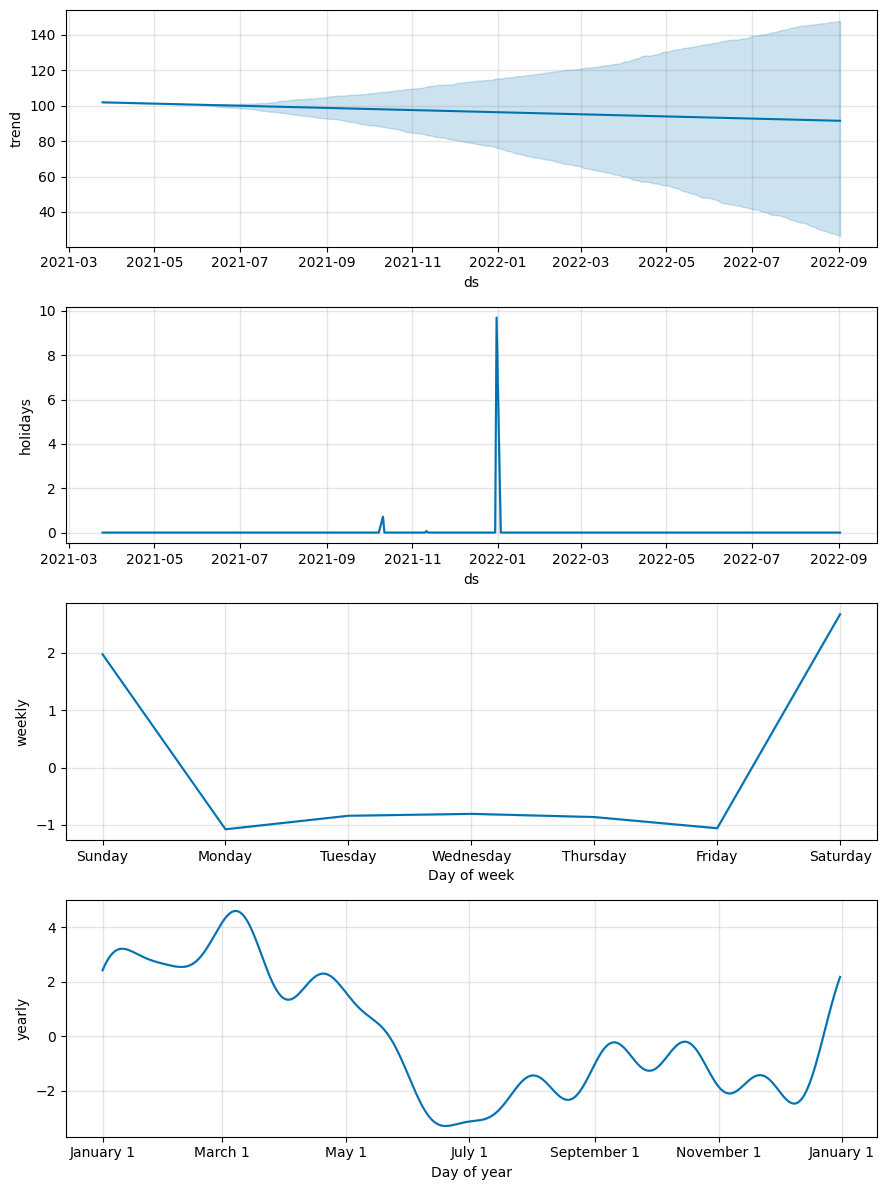

In [75]:
# on the test set
fig_test = plot_components(m=p, fcst=forecast_on_test)
fig_test.show()

C:\Users\evans\AppData\Local\Temp\ipykernel_17256\1222025171.py:3: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



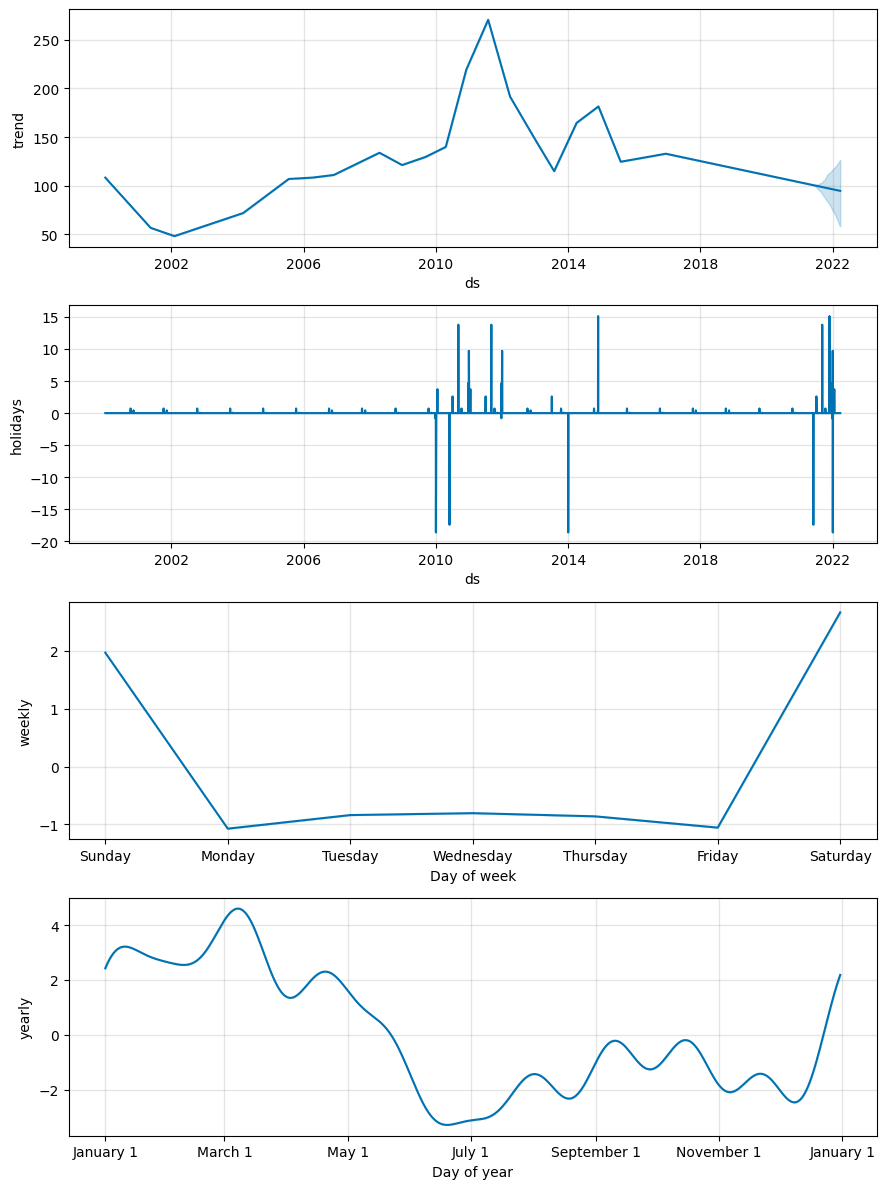

In [74]:
# On the original set
fig_og = plot_components(m=p, fcst=forecast)
fig_og.show()

## Conclusion

In this study, I conducted an analysis of the coffee stock price dataset spanning the years 2000-2020, aiming to forecast the closing price using a Prophet time series forecasting model. The Root Mean Squared Error (RMSE) between the actual and predicted values was found to be 110.24, indicating a certain level of discrepancy in the predictions. The dataset revealed a predominantly stable trend in coffee prices, with minor fluctuations, which aligns with the global demand for coffee. However, a notable exception was observed during 2011-2012, characterized by a significant price surge attributed to adverse weather and farming conditions leading to poor harvest.

The predictive model showed limitations in forecasting the coffee price for 2021-2022, which can be attributed to unforeseen factors, including poor weather conditions, drought, frost seasons, and ongoing supply chain disruptions due to the Covid-19 pandemic, primarily affecting major coffee-producing regions such as Brazil.

The analysis also unveiled a recurring pattern in the annual coffee price cycle, where prices tend to drop in May and rebound in late July. This consistent behavior aligns with the observed seasonality in the dataset, both for the prediction of the year 2022 and an additional 365-day period (year 2023) extrapolated from historical data.

While the forecasting model exhibited certain shortcomings in capturing the recent fluctuations, the broader trend analysis and insights drawn from historical data remain valuable. I acknowledge the need for continuous refinement of the model to address the impact of unforeseen events and external factors that may influence the coffee market, making the development of a more robust prediction model an area for future research.

Reference: The Guardian - "Commodities: Coffee shortage and price rise expected"
